In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR

In [2]:
def replace_nan(df):
    # get a list of all the columns containing NaN
    nan_cols = df[df.columns[df.isnull().any()]].columns
    nan_cols = nan_cols.drop('bikes')
    # compute and fill each NaN with the columns mean
    df[nan_cols] = df[nan_cols].fillna(value=df[nan_cols].mean())

    
def show_nans(df):
    print(np.unique(df['station']))
    print(df.shape[0] - df.dropna().shape[0])
#     print(df[df.columns[df.isnull().any()]].columns)
    print(df.isnull().any())
    print()
    

# converting weekdays into integers [1-7]
def convert_weekdays(df):
    df = df.replace(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    [1, 2, 3, 4, 5, 6, 7])
    return df
    
def score_abs_error(model, data, num_docks, round_ = False):
    if round_ == True:
        y_pred = np.around(  model.predict(data.iloc[:,:-1].to_numpy()))# * num_docks  )
    else:
        y_pred = model.predict(data.iloc[:,:-1].to_numpy())# * num_docks
    y_gold = data["bikes"].to_numpy()# * num_docks
    
    return mean_absolute_error(y_gold, y_pred)

def reasonable_predictions(model, data):
    y_pred = model.predict(data.to_numpy())
    
    y_pred = np.around(y_pred)
    return y_pred


## This code is added

In [3]:
pd.options.mode.chained_assignment = None

def is_hol_weekend(row):
    if row['weekday'] == 6 or row['weekday'] == 7:
        return 1
    if row['isHoliday'] == 1:
        return 1
    if row['hour'] > 17 or row['hour'] < 9:
        return 1
    return 0

def generate_dataframe(dataframe):
    dataframe = convert_weekdays(dataframe)
    
    # # deleting unneeded columns
    del dataframe["month"]
    del dataframe["year"]
    # del df["timestamp"]
    del dataframe["station"]
    del dataframe["precipitation.l.m2"]
    
    del dataframe["latitude"]
    del dataframe["longitude"]
    
    
    default_columns = list(dataframe.columns)
    
    dataframe['isOff'] = dataframe.apply(is_hol_weekend,axis=1)
    
    default_columns = ["isOff"] + default_columns
    
    dataframe = dataframe[default_columns]
    
    print(dataframe.columns)
    
    del dataframe['isHoliday']
    #del dataframe["timestamp"]
    
    
    columns = list(dataframe.columns[-6:])
    
    if "bikes" in columns:
        pass
    else:
        columns = columns[1:]
    
#     print(columns)
#     for c in columns:
#         dataframe[c] = dataframe[c].to_numpy() / dataframe["numDocks"].to_numpy()
    num_docks = dataframe["numDocks"]
    
    del dataframe["numDocks"]
    
    return dataframe, num_docks

def vectorise_dataframe(dataframe):
    
    # # deleting unneeded columns
    del dataframe["month"]
    del dataframe["year"]
    #del dataframe["timestamp"]
    del dataframe["station"]
    del dataframe["precipitation.l.m2"]
    #del dataframe["weekhour"]
    
    del dataframe["latitude"]
    del dataframe["longitude"]
    
    
    
    default_columns = list(dataframe.columns)
    #default_columns.remove('weekday')
    dataframe['isOff'] = dataframe.apply(is_hol_weekend,axis=1)
    
    #dataframe = pd.get_dummies(dataframe, columns=['weekday'])
    
    #default_columns = ["isOff", "weekday_Sunday", "weekday_Monday", "weekday_Tuesday", "weekday_Wednesday", 
                      #"weekday_Thursday", "weekday_Friday", "weekday_Saturday"] + default_columns
    
    default_columns = ["isOff"] + default_columns
    #del dataframe["weekday"]
    default_columns.remove('weekday')
    #print(default_columns)
    
    
    dataframe = dataframe[default_columns]
    
    #print(dataframe.columns)
    
    del dataframe['isHoliday']
    #del dataframe["timestamp"]
    
    
    columns = list(dataframe.columns[-6:])
    
    if "bikes" in columns:
        pass
    else:
        columns = columns[1:]
    
#     #print(columns)
#     for c in columns:
#         dataframe[c] = dataframe[c].to_numpy() / dataframe["numDocks"].to_numpy()
    num_docks = dataframe["numDocks"]
    
    dataframe["numDocks"]
    
    
    
    
#     columns_kept = ["weekday", "hour", "isOff",  'full_profile_3h_diff_bikes', 
#                      'short_profile_3h_diff_bikes',  "bikes"] #'bikes_3h_ago',
    
#     for c in dataframe.columns:
#         if c not in columns_kept:
#             del dataframe[c]
    
    
    return dataframe, num_docks

# Adding all files into one DataFrame
trains = []
vals = []

train_docks_list = []
val_docks_list = []

scalers = []
count = 0
for i, path in enumerate(Path('./Train/Train').rglob('*.csv')):
    count += 1

val_inds = list(np.random.randint(0, count - 1, 2))
print(val_inds)

for i, path in enumerate(Path('./Train/Train').rglob('*.csv')):
    tmp = pd.read_csv(path)

    tmp = tmp.dropna(axis='rows')
    
    #print(tmp.columns)

    
    if i  not in  val_inds:
        train, val = train_test_split(tmp, test_size=0.02)

        train, train_docks = vectorise_dataframe(train)
        val, val_docks = vectorise_dataframe(val)

        scaler = RobustScaler()
        
        train[train.columns[:-1]] = scaler.fit_transform(train[train.columns[:-1]])
        val[val.columns[:-1]] = scaler.transform(val[val.columns[:-1]])

        trains.append(train)
        vals.append(val)

        train_docks_list.append(train_docks)
        val_docks_list.append(val_docks)

        scalers.append(scaler)
        
        del tmp
    elif i == val_inds[0]:
        val_set = tmp.copy()


        val_set, val_set_docks = vectorise_dataframe(val_set)
    else:
        print('found val set two')
        val_set_two = tmp.copy()


        val_set_two, val_set_docks_two = vectorise_dataframe(val_set_two)


    
    

print(len(trains))

[10, 13]
found val set two
73


In [4]:
# forest = RandomForestRegressor(n_estimators=500, n_jobs=6)
# print("initialised")
# forest.fit(train.iloc[:,:-1].to_numpy(), train["bikes"].to_numpy())

# importances = forest.feature_importances_
# imp_indixes = np.argsort(importances)[::-1]
# feature_order = train.columns[:-1][imp_indixes]
# importances = importances[imp_indixes]

# imp_df = pd.DataFrame(data = importances, index = feature_order, columns=["relative_importance"])

# print(score_abs_error(forest, val, val_docks))

# print(imp_df)

# Random elimination parameter tuning
## Random forest regressor

This cell uses `HalvingRandomSearchCV` to find near-optimal parameters for a random forest regressor. It takes a while to run with these parameters.

In [5]:
from time import time
from tqdm import tqdm
start = time()
print("initialised")

models = []

for i in tqdm(range(len(trains))):
    #forest_boost = AdaBoostRegressor(n_estimators=400, random_state=0, learning_rate = 0.5)
    forest_boost = RandomForestRegressor(n_estimators= 200, max_depth= 9)
    #forest_boost = GradientBoostingRegressor(n_estimators= 150, max_depth= 3, learning_rate= 0.1, loss="squared_error")#
    forest_boost.fit(trains[i].iloc[:,:-1].to_numpy(), trains[i]["bikes"].to_numpy())
    
    models.append(forest_boost)
print(f'fitted in {time() - start}s')

initialised


100%|████████████████████████████████████████████| 73/73 [00:24<00:00,  3.00it/s]

fitted in 24.378346920013428s


100%|████████████████████████████████████████████| 73/73 [00:01<00:00, 65.24it/s]


Non-rounded ensemble error: 1.8163825114589298
Rounded ensemble error: 1.7945205479452055


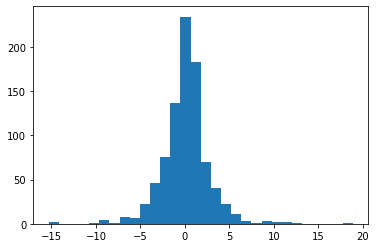

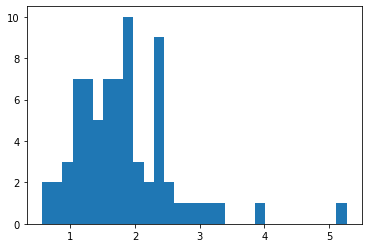

In [6]:
import matplotlib.pyplot as plt

errors = []
rounded_errors = []
y_pred = []
y_gold = []

for i in tqdm(range(len(vals))):
    errors.append(score_abs_error(models[i], vals[i], val_docks_list[i]))
    rounded_errors.append(score_abs_error(models[i], vals[i], val_docks_list[i], round_ = True))
    
    pred = list(models[i].predict(vals[i].iloc[:, :-1].to_numpy()))# * val_docks_list[i])
    
    y_pred = y_pred + pred
    
    y_gold = y_gold + list(vals[i]["bikes"])# * val_docks_list[i])
    
print(f'Non-rounded ensemble error: {np.mean(errors)}')
print(f'Rounded ensemble error: {np.mean(rounded_errors)}')

plt.hist(np.array(y_pred) - np.array(y_gold), bins=30)
plt.show()
plt.hist(errors, bins=30)
plt.show()

Error on validation holdout: 3.506096377480823


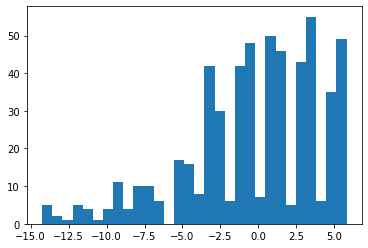

In [7]:
inds_best_models = np.argsort(errors)
#print(models)
best_model_ind = inds_best_models[0]
best_model = models[best_model_ind]
#print(best_model)



best_pred = best_model.predict(val_set.iloc[:, :-1].to_numpy())# * val_set_docks
val_gold = val_set["bikes"]# * val_set_docks

print(f'Error on validation holdout: {mean_absolute_error(val_gold, best_pred)}')

plt.hist(np.array(val_gold) - np.array(best_pred), bins=30)
plt.show()

0.9999999999999999


(array([ 6., 16., 17.,  8.,  5.,  5.,  3.,  4.,  2.,  0.,  2.,  1.,  0.,
         0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([0.00098738, 0.00383323, 0.00667909, 0.00952494, 0.0123708 ,
        0.01521665, 0.01806251, 0.02090836, 0.02375421, 0.02660007,
        0.02944592, 0.03229178, 0.03513763, 0.03798349, 0.04082934,
        0.04367519, 0.04652105, 0.0493669 , 0.05221276, 0.05505861,
        0.05790446, 0.06075032, 0.06359617, 0.06644203, 0.06928788,
        0.07213374, 0.07497959, 0.07782544, 0.0806713 , 0.08351715,
        0.08636301]),
 <BarContainer object of 30 artists>)

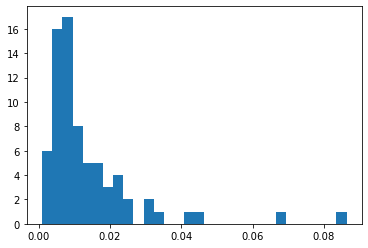

In [8]:
model_weights = np.array(errors)
model_weights = 1/ model_weights**(2)
model_weights = model_weights / np.sum(model_weights)
# should equal 1
print(np.sum(model_weights))

plt.hist(model_weights, bins=30)

['isOff' 'numDocks' 'timestamp' 'day' 'hour' 'weekhour' 'windMaxSpeed.m.s'
 'windMeanSpeed.m.s' 'windDirection.grades' 'temperature.C'
 'relHumidity.HR' 'airPressure.mb' 'bikes_3h_ago'
 'full_profile_3h_diff_bikes' 'full_profile_bikes'
 'short_profile_3h_diff_bikes' 'short_profile_bikes']
Validation error pre re-tuning:  4.765932979343766
[0.0440483  0.         0.01947527 0.0065645  0.04466275 0.05762842
 0.01114011 0.00935869 0.01631566 0.01576783 0.02247443 0.05386823
 0.05622416 0.02312525 0.30302858 0.0218408  0.29447701]


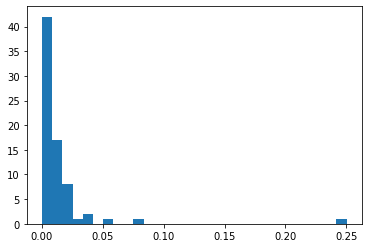

In [9]:
def ensemble_validation_errors(models, scalers, x, y,  docks):
    results = np.zeros(len(models))
    
    for i, m in enumerate(models):

        x_i = scalers[i].transform(x)
        
        results[i] = mean_absolute_error(m.predict(x_i),y)# * docks, y*docks)

    return results

#print(trains[0].columns)
#print(val_set.columns)
print(scalers[0].feature_names_in_)

validation_errors = ensemble_validation_errors(models, scalers, val_set.iloc[:, :-1], val_set["bikes"], val_set_docks)

print(f'Validation error pre re-tuning:  {np.mean(validation_errors)}')

model_weights = model_weights / validation_errors**2
model_weights = model_weights / np.sum(model_weights)

print(models[0].feature_importances_)


plt.hist(model_weights, bins=30)
plt.show()

2.1611566168378022


(array([ 3.,  2.,  3.,  2.,  2.,  2., 10., 15., 15., 21., 26., 30., 28.,
        43., 41., 51., 59., 44., 39., 34., 29., 19., 18., 13., 11.,  4.,
         2.,  0.,  1.,  1.]),
 array([-9.15916376, -8.59221815, -8.02527255, -7.45832694, -6.89138134,
        -6.32443573, -5.75749013, -5.19054453, -4.62359892, -4.05665332,
        -3.48970771, -2.92276211, -2.3558165 , -1.7888709 , -1.22192529,
        -0.65497969, -0.08803409,  0.47891152,  1.04585712,  1.61280273,
         2.17974833,  2.74669394,  3.31363954,  3.88058514,  4.44753075,
         5.01447635,  5.58142196,  6.14836756,  6.71531317,  7.28225877,
         7.84920438]),
 <BarContainer object of 30 artists>)

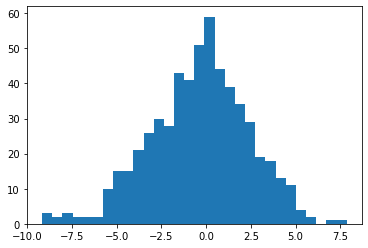

In [10]:
def ensemble_predict(models, scalers, model_weights, x):
    results = np.zeros(x.shape[0])

    for i, m in enumerate(models):

        x_i = scalers[i].transform(x)
        
        results = results + m.predict(x_i) * model_weights[i]

    return results

y_pred = ensemble_predict(models, scalers, model_weights, val_set_two.iloc[:,:-1]) #* val_set_docks_two

val_gold_two = val_set_two["bikes"].to_numpy()# * val_set_docks_two

print(mean_absolute_error(val_gold_two, y_pred))

plt.hist(val_gold_two - y_pred, bins=30)



(n_estimators= 100, min_samples_leaf= 5, max_depth= 5, learning_rate= 0.025, loss="absolute_error") = 6.171106155700234

## Score tracking

 -  vectorized data, n_estimators= 10000, min_samples_leaf= 5, max_depth= 5, learning_rate= 0.005, verbose = 1, loss="absolute_error", score 2.31, rounding integers 2.29
 
 - un-vectorized data, n_estimators= 10000, min_samples_leaf= 5, max_depth= 5, learning_rate= 0.005, verbose = 1, loss="absolute_error", score 2.33, rounding integers 2.31
 
 - vectorized data, n_estimators= 1000, min_samples_leaf= 5, max_depth= 5, learning_rate= 0.005, 2.43, 2.42
 
 - un-vectorized data, n_estimators= 1000, min_samples_leaf= 5, max_depth= 5, learning_rate= 0.005, , loss="absolute_error",  2.4, 2.38

In [11]:


# results = pd.DataFrame(search.cv_results_)
# results["params_str"] = results.params.apply(str)
# params = search.param_distributions
# # results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
# learning_rates = params["learning_rate"]
# mean_scores = results.pivot(
#     index="iter", columns="params_str", values="mean_test_score"
# )

# fig, ax = plt.subplots(figsize=(16,12))
# mean_scores.plot(legend=False, alpha=0.6, ax = ax, linewidth=8)

# labels = [
#     f"iter={i}\nn_samples={search.n_resources_[i]} \nn_candidates={search.n_candidates_[i]}"# \nn_estimators={params["n_estimators"][i]} "
#     for i in range(search.n_iterations_)
# ]

# ax.set_xticks(range(search.n_iterations_))
# ax.set_xticklabels(labels, rotation=45, multialignment="left")
# ax.set_title("Scores of candidates over iterations")
# ax.set_ylabel("mean test score", fontsize=15)
# ax.set_xlabel("iterations", fontsize=15)
# plt.tight_layout()
# plt.show()


In [12]:

# n_est = 10000

# import matplotlib.pyplot as plt
# test_score = np.zeros((n_est,), dtype=np.float64)

# y_test = val["bikes"]
# #y_pred = reasonable_predictions(forest_boost, val.iloc[:, :-1])

# for i, y_pred in enumerate(forest_boost.staged_predict(val.iloc[:,:-1])):
#     test_score[i] = forest_boost.loss_(y_test, y_pred)


# fig = plt.figure(figsize=(12
#                           , 12))
# plt.subplot(1, 1, 1)
# plt.title("Training and validation error")
# plt.plot(
#     np.arange(n_est) + 1,
#     forest_boost.train_score_,
#     "b-",
#     label="Training Set",
# )
# plt.plot(
#     np.arange(n_est) + 1, test_score, "r-", label="Validation Set"
# )
# plt.legend(loc="upper right")
# plt.xlabel("Boosting Iterations")
# plt.ylabel("Absolute error")
# #plt.yscale('log')
# fig.tight_layout()
# plt.show()

In [13]:
# plt.figure(figsize=(8,8))
# plt.hist(y_test*val_docks - forest_boost.predict(val.iloc[:,:-1])*val_docks, bins = 30)
# plt.show()

In [16]:
test = pd.read_csv('test.csv')

ids = test["Id"]

del test["Id"]
# del test["month"]
# del test["year"]

# convert_weekdays(test)
# # test[test.columns] = scaler.fit_transform(test[test.columns])

# for feature in lowest_ranked_10:
#     del test[feature]
    
# print(test.columns)  
# print(train.columns)

test, test_docks = vectorise_dataframe(test)

#y_pred = forest_boost.predict(test)
y_pred = np.around(ensemble_predict(models, scalers, model_weights, test)).astype(np.int32)

print(y_pred)

sub_df = pd.DataFrame(data=y_pred, index = ids, columns = ["bikes"])

sub_df.index.name = 'Id'

print(sub_df.head())

sub_df.to_csv("submission.csv")

[ 5  5 10 ...  8 12 11]
    bikes
Id       
1       5
2       5
3      10
4       5
5       5
